In [4]:
import random

class Ship:
    def __init__(self, size):
        self.size = size
        self.positions = []
        self.hits = 0

    def place_ship(self, board, start_row, start_col, direction):
        """Umieszcza statek na planszy"""
        if direction == "H":
            if start_col + self.size > len(board[0]):
                return False
            for i in range(self.size):
                if board[start_row][start_col + i] != " ":
                    return False
            for i in range(self.size):
                board[start_row][start_col + i] = "S"
                self.positions.append((start_row, start_col + i))
        else:
            if start_row + self.size > len(board):
                return False
            for i in range(self.size):
                if board[start_row + i][start_col] != " ":
                    return False
            for i in range(self.size):
                board[start_row + i][start_col] = "S"
                self.positions.append((start_row + i, start_col))
        return True

    def is_hit(self, row, col):
        """Zwraca True, jeśli statek został trafiony"""
        if (row, col) in self.positions:
            self.hits += 1
            return True
        return False

    def is_sunk(self):
        """Zwraca True, jeśli statek został zatopiony"""
        return self.hits == self.size


class Game:
    def __init__(self, board_size=5):
        self.board_size = board_size
        self.board = [[" " for _ in range(board_size)] for _ in range(board_size)]
        self.ships = []
        self.shots = set()  # Zbiór przechowujący oddane strzały
        self.shot_count = 0  # Zmienna licząca wykonane strzały
        self.hunt_mode = True  # Tryb Hunt (szukamy losowo)
        self.target_stack = []  # Stos celów w trybie Target
        self.last_hit = None  # Ostatnie trafienie (do Target Mode)
        

    def display_board(self, reveal=False):
        """Wyświetla planszę, jeśli reveal=True, pokazuje położenie statków"""
        # print("  " + " ".join([str(i) for i in range(self.board_size)]))
        # for i, row in enumerate(self.board):
        #     if reveal:
        #         print(str(i) + " " + " ".join(row))
        #     else:
        #         print(str(i) + " " + " ".join(["S" if x == "S" else x for x in row]))

    def add_ship(self, size):
        """Dodaje statek na planszy"""
        ship = Ship(size)
        placed = False
        while not placed:
            direction = random.choice(["H", "V"])
            start_row = random.randint(0, self.board_size - 1)
            start_col = random.randint(0, self.board_size - 1)
            placed = ship.place_ship(self.board, start_row, start_col, direction)
        self.ships.append(ship)

    def take_shot(self, row, col):
        """Gracz strzela w dane pole"""
        if row < 0 or row >= self.board_size or col < 0 or col >= self.board_size:
            #print("Poza planszą!")
            return False

        if self.board[row][col] == "X" or self.board[row][col] == "O":
            #print("Już tutaj strzelałeś!")
            return False

        hit = False
        for ship in self.ships:
            if ship.is_hit(row, col):
                #print("Trafiony!")
                self.board[row][col] = "X"
                hit = True
                self.last_hit = (row, col)  # Ustaw ostatnie trafienie
                if ship.is_sunk():
                    #print("Zatopiłeś statek!")
                    self.target_stack.clear()  # Wyczyszczenie stosu po zatopieniu
                break

        if not hit:
            #print("Pudło!")
            self.board[row][col] = "O"

        return hit

    def is_game_over(self):
        """Zwraca True, jeśli wszystkie statki zostały zatopione"""
        # print(all(ship.is_sunk() for ship in self.ships))
        return all(ship.is_sunk() for ship in self.ships)

    def add_adjacent_targets(self, row, col):
        """Dodaje sąsiadujące cele do stosu targetów"""
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Prawo, lewo, dół, góra
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if (0 <= new_row < self.board_size and 0 <= new_col < self.board_size and
                    (new_row, new_col) not in self.shots and (new_row, new_col) not in self.target_stack):
                self.target_stack.append((new_row, new_col))

    def random_shot(self):
        """Losowo wybiera nieodwiedzone pole i oddaje strzał"""
        while True:
            row = random.randint(0, self.board_size - 1)
            col = random.randint(0, self.board_size - 1)
            if (row, col) not in self.shots:
                self.shots.add((row, col))
                #print(f"Strzał na: {row}, {col}")
                hit = self.take_shot(row, col)
                self.shot_count += 1  # Zwiększ licznik strzałów
                if hit:
                    self.add_adjacent_targets(row, col)
                    self.hunt_mode = False  # Przechodzimy do Target Mode
                break

    def target_shot(self):
        """Strzela w jedno z pobliskich pól po trafieniu"""
        if self.target_stack:
            row, col = self.target_stack.pop()
            if (row, col) not in self.shots:
                self.shots.add((row, col))
                # print(f"Strzał na: {row}, {col} (Target Mode)")
                hit = self.take_shot(row, col)
                self.shot_count += 1
                if hit:
                    self.add_adjacent_targets(row, col)
                if not self.target_stack:
                    self.hunt_mode = True  # Wracamy do Hunt Mode, jeśli brak targetów
                return
        else:
            self.hunt_mode = True
            return

    def start_game(self, ship_sizes,only_random =False):
        """Rozpoczyna grę"""
        for size in ship_sizes:
            self.add_ship(size)

        #print("Rozmieszczenie statków zakończone!")
        # self.display_board(reveal=False)

        while not self.is_game_over():
            # self.display_board(reveal=False)
            if only_random or self.hunt_mode:
                self.random_shot()  # Losowe strzały w trybie Hunt
            else:
                self.target_shot()  # Celowane strzały w trybie Target


In [5]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    results = [0] * 101  # Lista 100 elementów, reprezentująca liczbę gier zakończonych w danej liczbie strzałów

    for _ in range(100000):  # Przeprowadzenie 1000 gier
        game = Game(board_size=10)  # Rozmiar planszy 10x10
        game.start_game([2, 3, 3])  # Statki o rozmiarach 2, 3, 3, 4, 5
        print(game.shot_count)
        # Jeśli liczba strzałów nie przekracza 100, zaktualizuj wyniki
        if game.shot_count < 101:
            results[game.shot_count] += 1
        else:
            print(game.shot_count)

    print(results)  # Wyświetlenie wyników
    data=results
    plt.figure(figsize=(10, 6))
    plt.plot(data, marker='o', linestyle='-', color='b')

    # Dodawanie etykiet
    plt.title('Wykres danych')
    plt.xlabel('Index')
    plt.ylabel('Value')

    # Wyświetlenie wykresu
    plt.grid(True)
    plt.show()

55
41
75
80
78
82
66
49
40
36
44
59
44
37
68
67
51
69
50
29
87
26
52
22
81
62
56
56
39
50
48
70
38
44
53
73
91
42
64
76
42
49
51
76
76
63
23
27
61
23
45
81
44
49
74
32
49
58
43
83
86
57
44
33
47
98
41
86
44
22
68
49
72
66
44
40
74
40
78
79
72
78
32
46
38
53
59
60
71
56
55
55
31
66
26
85
63
63
85
40
54
72
34
40
43
42
60
79
54
68
59
42
48
28
39
56
48
59
37
53
81
72
72
42
80
99
58
82
66
54
44
39
48
32
40
67
50
43
49
79
41
53
81
90
35
58
31
78
58
87
62
84
80
53
26
46
67
65
57
47
97
71
70
69
73
41
67
64
30
88
92
62
56
47
61
43
70
87
67
51
36
71
78
73
62
84
49
35
74
51
35
60
53
52
55
64
93
88
75
35
56
57
33
55
83
88
73
31
78
38
81
48
56
89
63
57
51
97
86
27
37
50
66
62
45
34
58
52
64
82
93
71
63
47
63
55
89
62
96
57
61
61
79
65
65
40
63
40
66
40
67
51
61
61
33
54
58
69
76
57
64
69
97
82
48
74
57
60
38
40
60
59
39
73
67
59
74
50
63
83
77
89
46
37
47
60
66
54
33
66
67
71
36
88
40
52
38
65
47
73
55
74
43
90
72
36
59
43
47
38
43
59
29
59
55
50
76
38
60
29
39
63
49
36
35
60
63
37
44
44
60
48
15
2

KeyboardInterrupt: 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 4, 3, 4, 7, 5, 5, 11, 13, 19, 14, 18, 23, 25, 33, 35, 53, 40, 42, 67, 80, 73, 73, 113, 132, 133, 173, 201, 198, 241, 244, 294, 350, 358, 435, 430, 512, 581, 646, 732, 782, 948, 946, 1108, 1162, 1322, 1461, 1588, 1659, 1848, 2045, 2231, 2491, 2634, 2948, 3139, 3426, 3730, 3947, 4353, 4609, 5097, 5513, 5946, 6373, 6788, 7353, 8128]


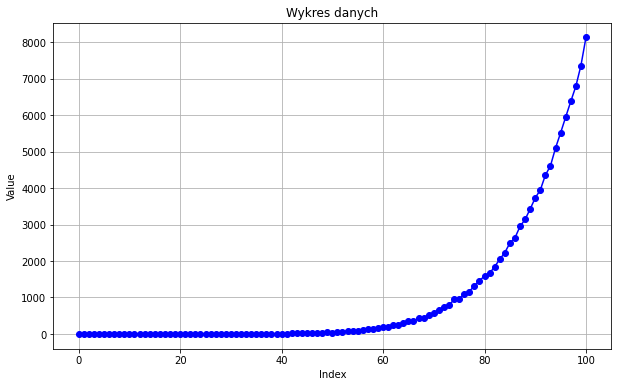

In [80]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    results2 = [0] * 101  # Lista 100 elementów, reprezentująca liczbę gier zakończonych w danej liczbie strzałów

    for _ in range(100000):  # Przeprowadzenie 1000 gier
        game = Game(board_size=10)  # Rozmiar planszy 10x10
        game.start_game([2, 3, 3],True)  # Statki o rozmiarach 2, 3, 3, 4, 5
        # Jeśli liczba strzałów nie przekracza 100, zaktualizuj wyniki
        if game.shot_count < 101:
            results2[game.shot_count] += 1
    

    print(results2)  # Wyświetlenie wyników
    data=results2
    plt.figure(figsize=(10, 6))
    plt.plot(data, marker='o', linestyle='-', color='b')

    # Dodawanie etykiet
    plt.title('Wykres danych')
    plt.xlabel('Index')
    plt.ylabel('Value')

    # Wyświetlenie wykresu
    plt.grid(True)
    plt.show()

No handles with labels found to put in legend.


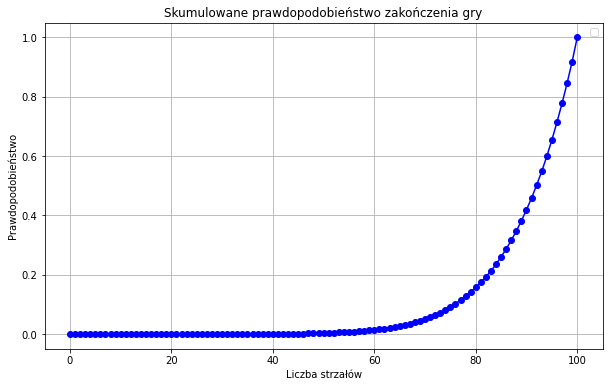

In [81]:
import numpy as np
# Obliczanie skumulowanej częstości
cumulative_results = np.cumsum(results2)
cumulative_probability = cumulative_results / cumulative_results[-1]  # Normalizacja

# Wykres
plt.figure(figsize=(10, 6))
plt.plot(cumulative_probability, marker='o', linestyle='-', color='b')

# Dodawanie etykiet
plt.title('Skumulowane prawdopodobieństwo zakończenia gry')
plt.xlabel('Liczba strzałów')
plt.ylabel('Prawdopodobieństwo')

# Wyświetlenie wykresu
plt.grid(True)
plt.legend()
plt.show()

No handles with labels found to put in legend.


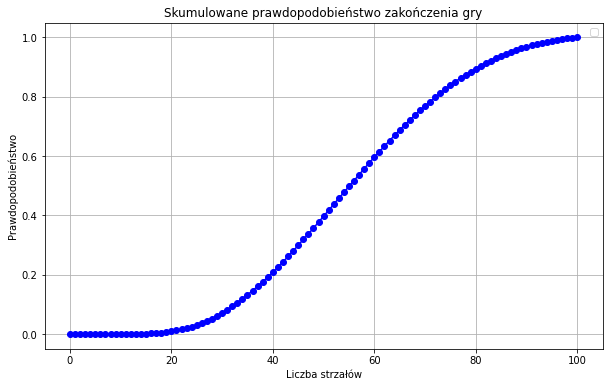

In [77]:
import numpy as np
# Obliczanie skumulowanej częstości
cumulative_results = np.cumsum(results)
cumulative_probability = cumulative_results / cumulative_results[-1]  # Normalizacja

# Wykres
plt.figure(figsize=(10, 6))
plt.plot(cumulative_probability, marker='o', linestyle='-', color='b')

# Dodawanie etykiet
plt.title('Skumulowane prawdopodobieństwo zakończenia gry')
plt.xlabel('Liczba strzałów')
plt.ylabel('Prawdopodobieństwo')

# Wyświetlenie wykresu
plt.grid(True)
plt.legend()
plt.show()